In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from stockstats import StockDataFrame

# libraries for plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Use Pandas to reformat columns to be displayed as currency
pd.options.display.float_format = '{:6.2f}'.format

In [2]:
data = yf.download(
        tickers = "SOXL",
        period = "5y",
    
        # Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
        interval = "1wk",
        group_by = 'ticker',
)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-03,4.96,5.07,4.93,5.03,4.94,2850000.00
2017-04-10,5.03,5.04,4.45,4.45,4.37,24531000.00
2017-04-17,4.49,5.01,4.49,4.92,4.83,22833000.00
2017-04-24,5.13,5.39,5.05,5.10,5.01,30136500.00
2017-05-01,5.15,5.25,4.99,5.17,5.08,18129000.00


In [3]:
def convert_df_to_stock_df(df):    
    df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'amount',
        'Volume': 'volume',
    }, inplace=True)
    df.index.names = ['date']
    return StockDataFrame(df)

sdf = convert_df_to_stock_df(data)
sdf.head()

,open,high,low,close,amount,volume
date,,,,,,
2017-04-03,4.96,5.07,4.93,5.03,4.94,2850000.00
2017-04-10,5.03,5.04,4.45,4.45,4.37,24531000.00
2017-04-17,4.49,5.01,4.49,4.92,4.83,22833000.00
2017-04-24,5.13,5.39,5.05,5.10,5.01,30136500.00
2017-05-01,5.15,5.25,4.99,5.17,5.08,18129000.00


In [4]:
sdf['rsi']

# 売られすぎ、買われすぎのデータを追加
overbought_rsi = 70
oversold_rsi = 40

sdf['is_overbought'] = False
sdf['is_oversold'] = False
for index, row in sdf.iterrows():
    sdf.loc[index, 'is_overbought'] = sdf.loc[index]['rsi'] >= overbought_rsi
    sdf.loc[index, 'is_oversold'] = sdf.loc[index]['rsi'] <= oversold_rsi
sdf.head()

,open,high,low,close,amount,volume,rs_14,rsi,is_overbought,is_oversold
date,,,,,,,,,,
2017-04-03,4.96,5.07,4.93,5.03,4.94,2850000.00,NaN,NaN,False,False
2017-04-10,5.03,5.04,4.45,4.45,4.37,24531000.00,0.00,0.00,False,True
2017-04-17,4.49,5.01,4.49,4.92,4.83,22833000.00,0.87,46.45,False,False
2017-04-24,5.13,5.39,5.05,5.10,5.01,30136500.00,1.23,55.18,False,False
2017-05-01,5.15,5.25,4.99,5.17,5.08,18129000.00,1.40,58.34,False,False


In [5]:
# 売られすぎた日
print("Total oversold day : " ,(sdf['is_oversold'] == True).sum())

# 買われすぎた日
print("Total overbought day : " ,(sdf['is_overbought'] == True).sum())

Total oversold day :  17
Total overbought day :  34


<Figure size 792x576 with 0 Axes>

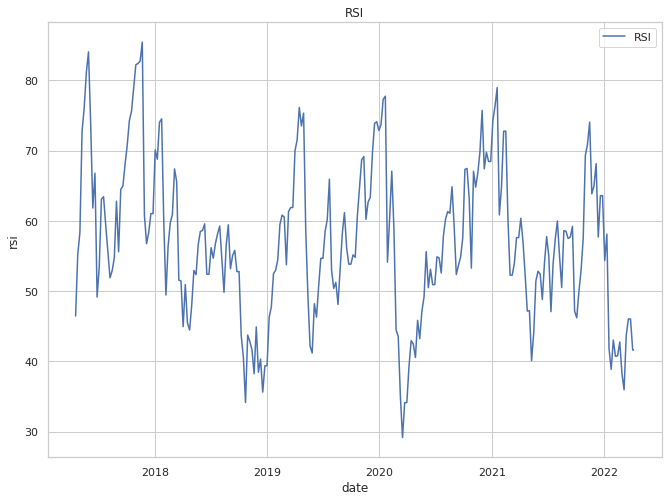

<Figure size 792x576 with 0 Axes>

In [6]:
plot_data = sdf.copy()
plot_data['rsi']

# rsiが計算できないデータを除外
for index, row in plot_data.iterrows():
    if row['rsi'] == 0 or np.isnan(row['rsi']) or np.isnan(row['amount']):
        plot_data = plot_data.drop(index)
        
# plot rsi
sns.set(rc={'figure.figsize':(11,8)}) 
sns.set_style('whitegrid') 
plt.ticklabel_format(style='plain', axis = 'y') 
sns.lineplot(data = plot_data, x= 'date', y = 'rsi').set_title('RSI')
plt.legend(labels=["RSI"])
plt.figure()

# sns.scatterplot(data = plot_data, x= 'date', y = 'is_oversold')
# sns.scatterplot(data = plot_data, x= 'date', y = 'is_overbought')
# plt.legend(labels=["is_oversold", 'is_overbought'])

In [7]:
# now we need to define the parameters of our dollar cost average
# the starting principal
p = 10000

# the amount to dollar cost average per month
add = 10 # USD

In [8]:
data = sdf.copy()

data['principal'] = p

# RSIの購入パターン
data['rsi_current_value'] = p # 現在の試算評価額（ドル建）
data['rsi_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['rsi_capacity_to_buy'] = 0 # 買い付け余力金

# DCAの購入パターン
data['dca_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['dca_capacity_to_buy'] = 0 # 買い付け余力金

previous_index = sdf.index[0]

for index, row in data.iterrows():
    data.loc[index, 'principal'] = data.loc[previous_index, 'principal'] + add;
    data.loc[index, 'rsi_capacity_to_buy'] += data.loc[previous_index, 'rsi_capacity_to_buy'] + add;
    
    if data.loc[index,'is_oversold'] and data.loc[index, 'rsi_capacity_to_buy'] >= data.loc[index, 'amount']:
        data.loc[index, 'rsi_shares'] = (data.loc[index, 'rsi_capacity_to_buy'] // data.loc[index, 'amount']) + data.loc[previous_index, 'rsi_shares']
        data.loc[index, 'rsi_capacity_to_buy'] = data.loc[index, 'rsi_capacity_to_buy'] % data.loc[index, 'amount']
    else:
        data.loc[index, 'rsi_shares'] = data.loc[previous_index, 'rsi_shares']
        
    data.loc[index, 'rsi_current_value'] = data.loc[index, 'amount'] * data.loc[index, 'rsi_shares']
    
    previous_index = index
    
result_data = data
result_data

,open,high,low,close,amount,volume,rs_14,rsi,is_overbought,is_oversold,principal,rsi_current_value,rsi_shares,rsi_capacity_to_buy,dca_shares,dca_capacity_to_buy
date,,,,,,,,,,,,,,,,
2017-04-03,4.96,5.07,4.93,5.03,4.94,2850000.00,NaN,NaN,False,False,10010,9995.36,2024.00,10.00,2024.00,0
2017-04-10,5.03,5.04,4.45,4.45,4.37,24531000.00,0.00,0.00,False,True,10020,8867.65,2028.00,2.51,2024.00,0
2017-04-17,4.49,5.01,4.49,4.92,4.83,22833000.00,0.87,46.45,False,False,10030,9791.99,2028.00,12.51,2024.00,0
2017-04-24,5.13,5.39,5.05,5.10,5.01,30136500.00,1.23,55.18,False,False,10040,10151.91,2028.00,22.51,2024.00,0
2017-05-01,5.15,5.25,4.99,5.17,5.08,18129000.00,1.40,58.34,False,False,10050,10307.30,2028.00,32.51,2024.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,38.70,42.37,36.59,42.01,42.00,192282600.00,0.85,46.03,False,False,12730,96647.66,2301.00,43.39,2024.00,0
2022-03-22,NaN,NaN,NaN,NaN,NaN,NaN,0.85,46.03,False,False,12740,NaN,2301.00,53.39,2024.00,0
2022-03-28,41.20,46.00,34.62,36.29,36.29,210148300.00,0.85,46.03,False,False,12750,83503.29,2301.00,63.39,2024.00,0


<Figure size 792x576 with 0 Axes>

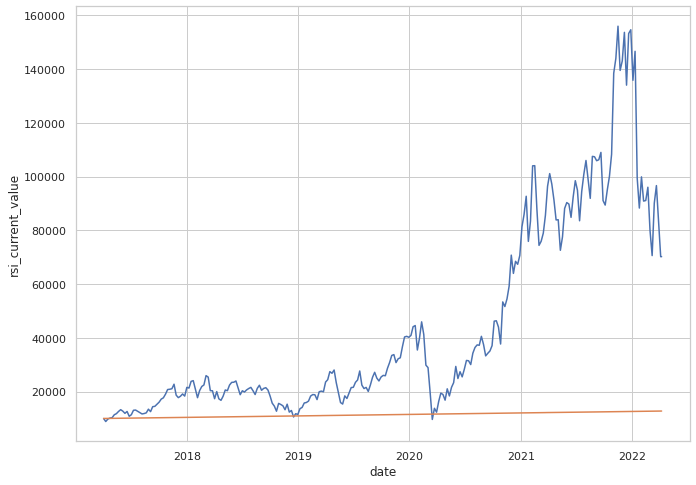

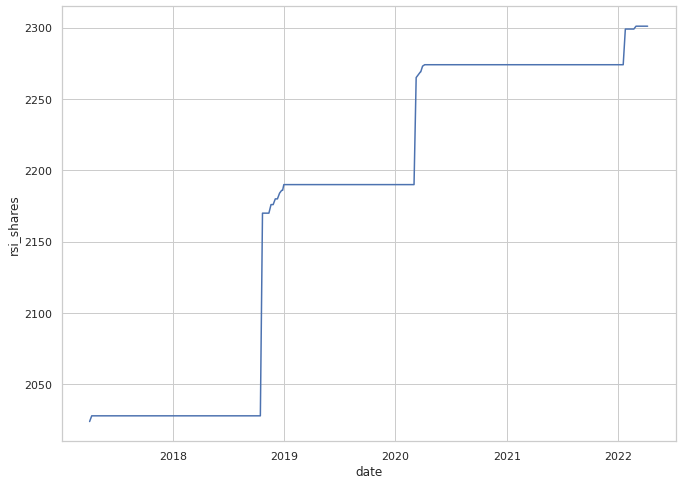

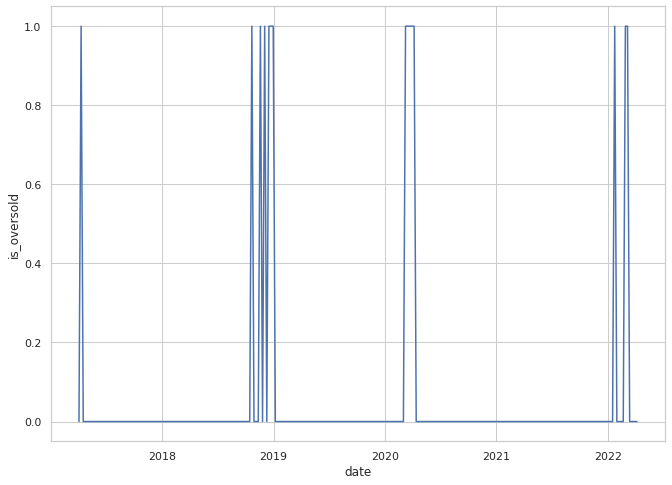

<Figure size 792x576 with 0 Axes>

In [9]:
plot_data = result_data.copy()

# Now Let's go ahead and plot it out
sns.set(rc={'figure.figsize':(11,8)}) # Change the size of the plot
sns.set_style('whitegrid') # Change the default background
plt.ticklabel_format(style='plain', axis = 'y') # prevent sci notation on y-axis

# now for the actual plot
# sns.lineplot(data = plot_data, x= 'date', y = 'amount')
# sns.lineplot(data = plot_data, x= 'date', y = 'capacity_to_buy')
sns.lineplot(data = plot_data, x= 'date', y = 'rsi_current_value')
sns.lineplot(data = plot_data, x= 'date', y = 'principal')
plt.figure()

sns.lineplot(data = plot_data, x= 'date', y = 'rsi_shares')
plt.figure()

sns.lineplot(data = plot_data, x= 'date', y = 'is_oversold')
plt.figure()